# Introduction to Logistic Regression

### Introduction

Now so far we have seen how, with a bernoulli distribution we can model the probability of an event occurring or not.  So far, this calculation has been fairly simple.  We say that given a sample space of $X = \{0, 1\} $, $p(x = 1) = p$, and $p(x = 0) = 1 - p$.

Of course, oftentimes we want to consider various factors that will influence the probability of an event.  For example, we may consider different characteristics of cancer cells, that will lead to an assignment of probabilities of cancer, based on these probabilities.  To make calculations like that, we can turn to logistic regression.

### Introducing our Problem

Let's introduce ourselves to logistic regression by working with the famous breast cancer dataset.  The dataset was formed by researchers looking at different slides of patient cells, and for each slide the researchers indicated features of the cells on the slide (like the mean area), as well as if cancerous cells were present on the slide, the target.  

Let's load up our dataset and get started.

In [3]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

In [5]:
import pandas as pd
X = pd.DataFrame(dataset['data'], columns = dataset['feature_names'])
y = pd.Series(dataset['target'])

In [6]:
X[:3]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


If we look at the feature names, we can see some of the features that were observed.  

In [149]:
X.shape

(569, 30)

### Visualizing our problem

Let's begin by plotting two features of our dataset, along with the associated outcomes.

In [12]:
cancerous_df = X[y == 1]
benign_df = X[y == 0]

In [14]:
mean_area_cancerous = cancerous_df['mean area']
mean_area_benign = benign_df['mean area']
concavity_cancerous = cancerous_df['mean concavity']
concavity_benign = benign_df['mean concavity']

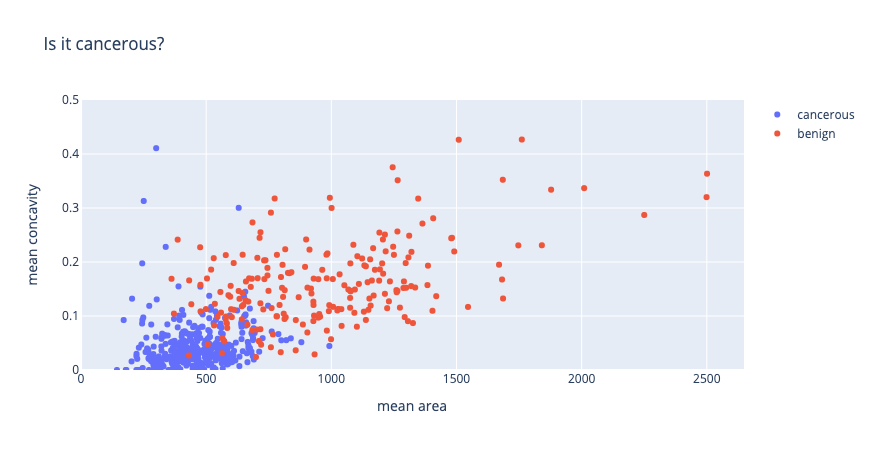

In [18]:
import plotly.graph_objects as go
cancerous_scatter = go.Scatter(x = mean_area_cancerous, y = concavity_cancerous, name = 'cancerous', mode = 'markers')
benign_scatter = go.Scatter(x = mean_area_benign, y = concavity_benign, name = 'benign', mode = 'markers')
layout = {'xaxis': {'title': 'mean area'},
          'yaxis': {'title': 'mean concavity', 
                    'range': [0, .5]}, 'title': 'Is it cancerous?'}
go.Figure([cancerous_scatter, benign_scatter], layout = layout)

So we can see that there is a trend in the data.  In fact, if we were going to infer a trend in the data, it would may be to draw a line dividing the data.  If the data falls on one side of the line, we predict the observation to be cancerous, and otherwise we predict the observation is benign.  This dividing line is called the logistic regression model's **decision boundary**.   Let's train a model and see it action.

### Our problem

Ok, now let's train a logistic regression model using sklearn.

In [20]:
from sklearn.linear_model import LogisticRegression
scoped_df = X[['mean area', 'mean concavity']]

model = LogisticRegression()
model.fit(scoped_df, y)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Now after fitting our logistic regression model, we are given a set of parameters just like we saw with linear regression.  But this time our parameters are used to create our decision boundary.

In [23]:
model.coef_

array([[-0.00802333, -3.47361781]])

In [24]:
model.intercept_

array([5.86599622])

In [27]:
def decision_boundary_y(x, coefs, intercept):
    coef_pair = coefs[0]
    return (coef_pair[0]/coef_pair[1])*x + intercept[0]/coef_pair[1]

We can plot our decision boundary by calling our function above with a range of values.

In [28]:
area_values = list(range(500, 1000, 5))
boundaries = [decision_boundary_y(idx, model.coef_, model.intercept_) for idx in area_values]

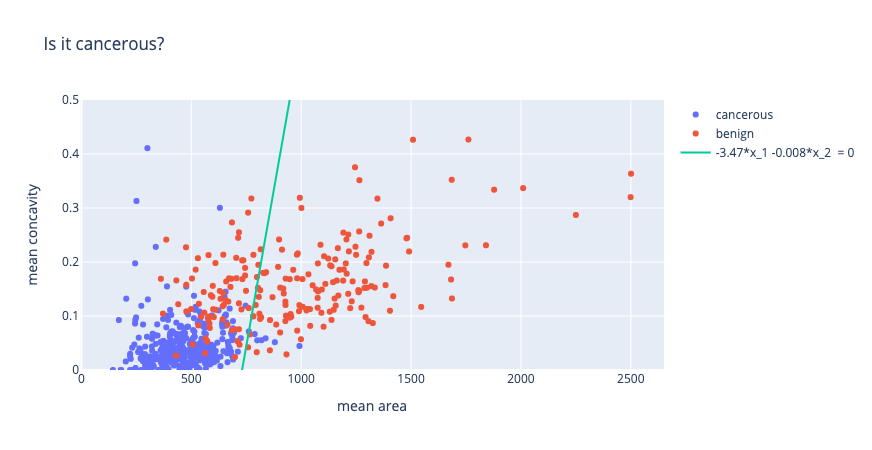

In [30]:
decision_trace = go.Scatter(x=area_values, y=boundaries, mode = 'lines', name = '-3.47*x_1 -0.008*x_2  = 0')

layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'mean concavity', 'range': [0, .5]}, 'title': 'Is it cancerous?'}
go.Figure([cancerous_scatter, benign_scatter, decision_trace], layout = layout)

Let's take a look at the diagram above.  The green line is the fitted decision boundary.  We'll discuss how that model came to the decision boundary when we discuss the cost function.  But for now, let's just take it as given that this boundary makes sense.

Now this boundary indicates the predictions of our model.  Everything to the right of the line is predicted as benign, and everything to the left of the line is predicted as cancerous.

Now that we understand how the model works, we can see that there are a half dozen orange cancerous points on the benign side of the line.  And there are many more benign observed cells on the cancerous side of our decision boundary.  That's ok, we don't expect our model to be perfect in it's predictions.

### Our predictions mathematically

So we how we can use our decision boundary to visually see if our model predicts a value as being cancerous or non-cancerous.  We can also use our trained parameters to predict our outcomes.

Let's take another look at our model parameters.

In [159]:
model.coef_

array([[-0.00802333, -3.47361781]])

In [160]:
model.intercept_

array([5.86599622])

We can use these parameters to define the following function. 

In [37]:
def decision_boundary_function(mean_area, mean_concavity):
    return -0.00802333*mean_area - 3.47361781 * mean_concavity + 5.86599622

And if our function outputs a positive number, we'll predict our datapoint as being one, or cancerous.  If our function outputs a negative number, then we'll interpret our datapoint as 0, or benign.

Now we could pass our data through our function above, but sklearn gives us this function for free.  

In [47]:
model.decision_function(X[['mean area', 'mean concavity']])[17:23]

array([-1.14119896, -4.75715111,  1.090901  ,  1.53518833,  3.56572524,
       -0.50710978])

And we can even turn these outputs into predictions of 1 or 0.

In [46]:
model.predict(scoped_df[['mean area', 'mean concavity']])[17:23]

array([0, 0, 1, 1, 1, 0])

And note that on this sample, this does a good job of predicting this snippit of data.

In [34]:
updated_df = scoped_df.assign(y = y)
updated_df.loc[17:22, :]

,mean area,mean concavity,y
17,798.8,0.17220,0
18,1260.0,0.14790,0
19,566.3,0.06664,1
20,520.0,0.04568,1
21,273.9,0.02956,1
22,704.4,0.20770,0


### Summary

In this lesson, we learned about the classification problem and how we can use logistic regression to predict whether an observation is likely to fall into one group or another.  We saw that with a classification problem, the values of our observed labels are discrete.  In our example, they were either one or zero to indicate a cancerous cell or not.  We use the features to fit a decision function that predicts if an observation is positive or negative.  If we pass the feature variables of an observation into a decision function, the sign of the return value is used to make a positive (cancerous) or negative observation.  That is, when our decision function returns a positive value, we predict a value of one, and when our decision function returns a negative value of zero. 

# Likelihoods with Logistic Regression

## Introduction

Let's take another look at our graph of observations alog with the decision function.

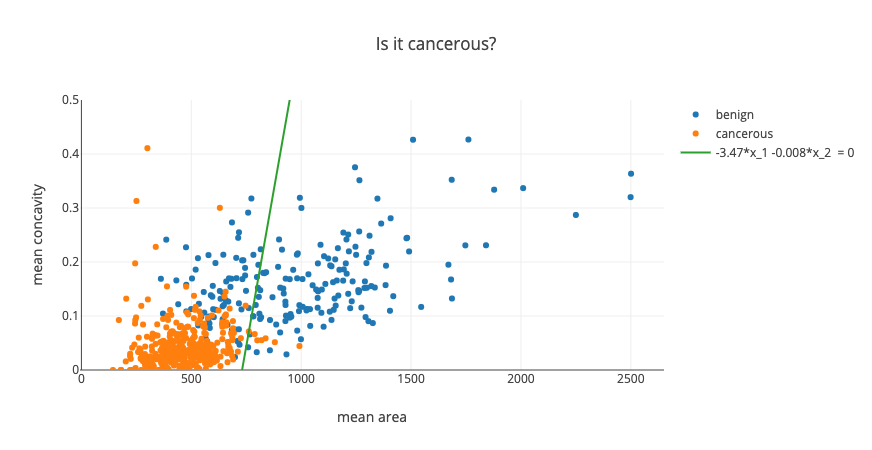

In [167]:
decision_trace = trace_values(x_values=area_values, y_values=boundaries, mode = 'lines', name = '-3.47*x_1 -0.008*x_2  = 0')

layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'mean concavity', 'range': [0, .5]}, 'title': 'Is it cancerous?'}
plot([non_cancerous_trace, cancerous_trace,  decision_trace], layout = layout)

Now, as we saw in the last lesson, we use the green line to predict whether a datapoint is cancerous.  Those datapoints on the right side of the line are predicted to be benign, and those to the left of the line are predicted to be cancerous.  

### This time, with Confidence

Now our decision function can do more than just predict whether a datapoint is positive or negative.  It also indicates the confidence with which we make the prediction.  Looking at the graph, we can see how this can work.  The further our datapoints are from the decision function, the more confident we can be in the prediction.  And the closer the datapoints are to the decision boundary, the less confident.  After all, it is the points relatively close to the decision function that are misclassified.  But as we move away from our decision boundary, we see fewer misclassifications.

So we can begin to think of these distances as expressing a likelihood, which is valuable information to have.  

So let's take another look at our decision function:

In [168]:
def decision_boundary_function(mean_area, mean_concavity):
    return -0.00802333*mean_area - 3.47361781 * mean_concavity + 5.86599622

When we pass observations into our decision function, we no longer just care about whether the output is positive or negative.  But we also care about how positive or negative this return value is.  The more positive or negative, the more confident we are in our prediction.  Where our decision function outputs zero, we are saying that our model is predicting a fifty-fifty chance of either outcome.

So if we start plugging in different observations into our decision function, we can compare the outputs.   

In [169]:
# make predictions here

But it still would be nice if we could translate these outputs, which we can call our *scores* into probabilities.

### Working with Probabilities

Let's think about how we would like to translate our scores into a probability of a cell being cancerous.  Now that we are in the realm of probability, we talk about the probabiity of an event occurring.  An *event* is just something of interest.  Here a cell being cancerous.  These are some other things to remember about probability:

* The probability of any given event is always between zero and one.
* The closer a probability is to one, the more confident we are in the event occurring.  
* The closer a probability is to zero, the more confident we are in the event *not* occurring.  

Now remember that the whole reason we are talking about probability is because we noticed that we can use an observation's distance from the decision function to indicate the likelihood that the event will occur.  More specifically, the more negative a decision function's output, the more confident we are that the event will not occur.  And the more positive the decision function's output, the more confident we are that the event will occur (ie. that the cell will be cancerous).  

So we want our large negative outputs to turn into a number close to zero, and our large positive outputs to turn into a number close to one, and our output of zero to turn into the number .5.

It turns out the sigmoid function does just that.  This is the sigmoid function.

### Introducing the sigmoid function

The sigmoid function is the function $S$ defined as: 

$$ S(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$ 

Here, $x$ is the score that is returned from our decision function.

Remember our goals, we wanted a function that did the following: 

* equaled one half when $x = 0$ 
* transformed our large negative scores to a value close to zero 
* transformed our large positive scores to a value close to one

1. When $x = 0$ we have:

$$ S(0) = \frac{1}{1 + e^{-0}} = \frac{e^0}{e^0 + 1} = \frac{1}{1 + 1} = \frac{1}{2}$$ 

2. When $x = -100$ (a somewhat large negative number) we have:

$$ S(-100) = \frac{1}{1 + e^{- (-100)}} = \frac{1}{1 + e^{100}} \approx \frac{1}{1 + \infty} \approx \frac{1}{\infty} \approx 0 $$ 

2. When $x = 100$ (a somewhat large positive number) we have:

$$ S(-100) = \frac{1}{1 + e^{-100}} = \frac{1}{1 + \frac{1}{e^{100}}} = \frac{1}{1 + 0} \approx 1 $$ 

So we can see that this function appears to meet our conditions, and would work well for us.  Now when we have a decision function, it can take the distances of the points from the decision function.  If the distance is far from the line in the positive direction, we return a probability close to one.  If it's far from the line in the negative direction, we return a probability close to zero.  And if the distance is near the line we return a probability close to fifty percent. 

Ok, it's time to plot our sigmoid function.

### Plotting the Sigmoid Function

To plot the sigmoid function, let's first translate it into a function.

In [170]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

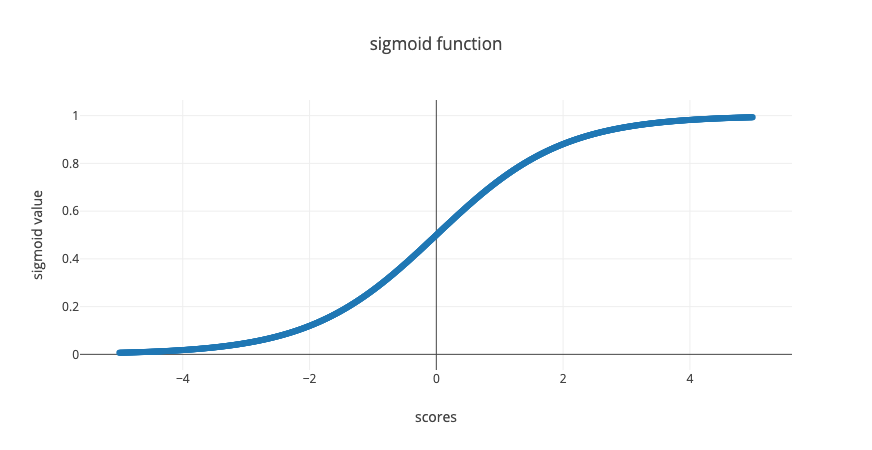

In [171]:
from graph import trace_values, plot
x_values = [scaled_x/100 for scaled_x in list(range(-500, 500))]
y_values = [sigmoid(x) for x in x_values]

sigmoid_trace = trace_values(x_values, y_values)
plot([sigmoid_trace], {'title': 'sigmoid function', 'xaxis': {'title': 'scores'}, 'yaxis': {'title': 'sigmoid value'}})

So this is the famous sigmoid function.  And it follows the rules that we established above.  It approaches zero as $x$ becomes more negative, and approaches one as $x$ becomes more positive.  And it returns .5 when crossing x-axis. 

### From decision boundary plot to sigmoid plot

Ok, let's go back to our original problem of identifying cancer cells.  Remember that our goal is to find a decision function that differentiates between benign and cancerous cell.  This is our plot.

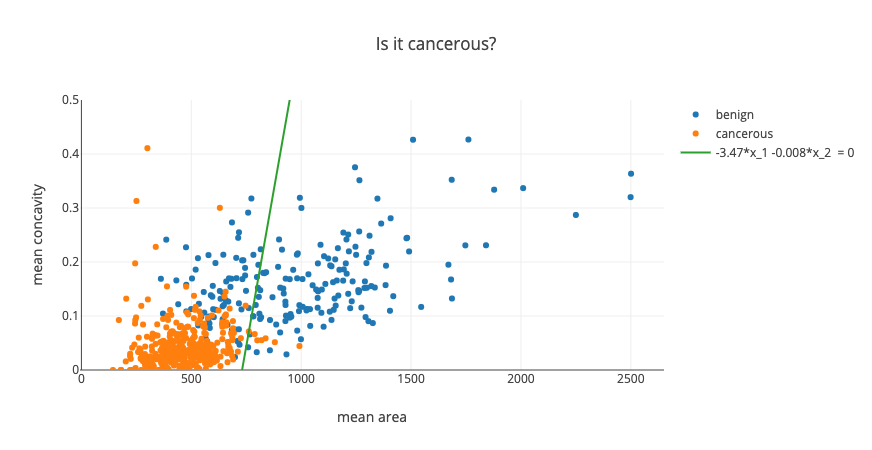

In [172]:
decision_trace = trace_values(x_values=area_values, y_values=boundaries, mode = 'lines', name = '-3.47*x_1 -0.008*x_2  = 0')

layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'mean concavity', 'range': [0, .5]}, 'title': 'Is it cancerous?'}
plot([non_cancerous_trace, cancerous_trace,  decision_trace], layout = layout)

Now, we can get a sense of how confident we are in each of our points.

So we already saw how we can predict each of our datapoints.  We simply take the features and pass them through our decision function.

In [178]:
scoped_df.set_copy = False
prediction_scores = scoped_df.loc[:, ['mean_area', 'mean_concavity']].apply(lambda x: decision_boundary_function(*x), axis=1)
scoped_df.loc[:, 'prediction_scores'] = prediction_scores

And then we can convert our scores into prediction probabilities using our `sigmoid` function.

In [179]:
prediction_probs = scoped_df.loc[:, 'prediction_scores'].apply(lambda x: sigmoid(x))
scoped_df.loc[:, 'prediction_probs'] = prediction_probs
scoped_df[:3]

,mean_area,mean_concavity,y,prediction_scores,prediction_probs
0,1001.0,0.3001,0,-3.207790,0.038874
1,1326.0,0.0869,0,-5.074797,0.006214
2,1203.0,0.1974,0,-4.471762,0.011298


Now we can see how our scores translate to prediction probabilities.

In [180]:
df_benign, df_cancerous = [x for _, x in scoped_df.groupby(scoped_df['y'] == 1)]

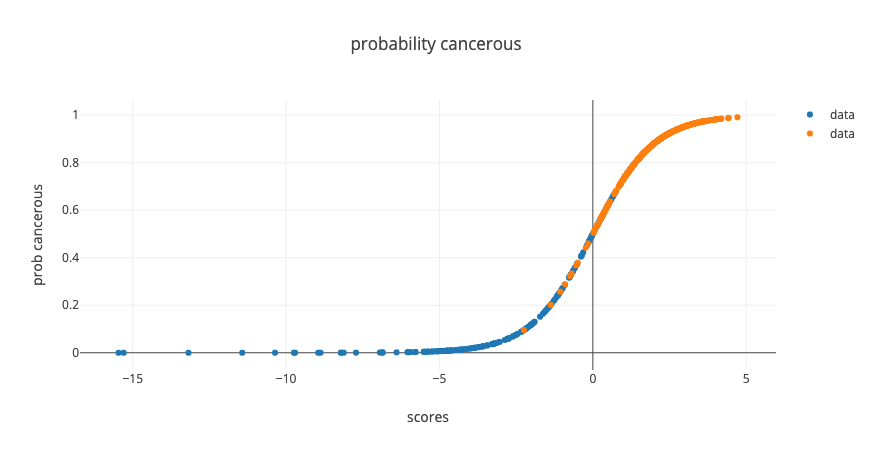

In [181]:
benign_sigmoid_trace = trace_values(df_benign['prediction_scores'], df_benign['prediction_probs'])
cancerous_sigmoid_trace = trace_values(df_cancerous['prediction_scores'], df_cancerous['prediction_probs'])
plot([benign_sigmoid_trace, cancerous_sigmoid_trace], layout = {'xaxis': {'title': 'scores'}, 'yaxis': {'title': 'prob cancerous'}, 'title': 'probability cancerous'})

So we can see our classifier is assigning a higher likelihood of the cancerous cells in fact being cancerous.

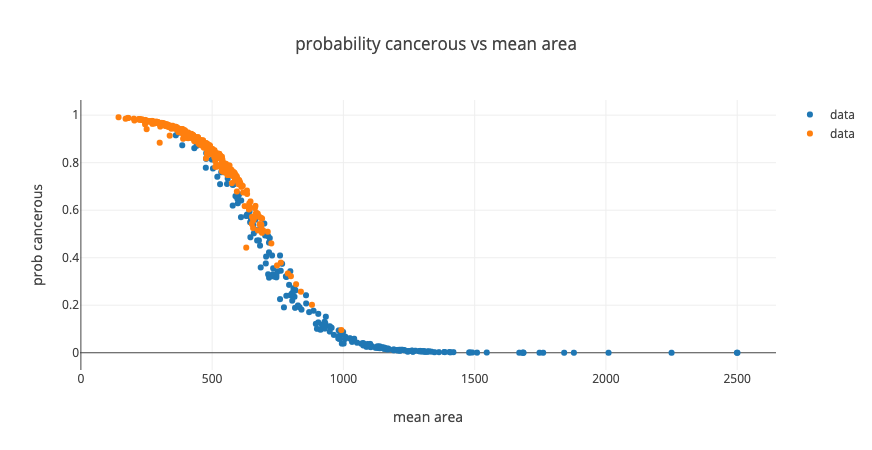

In [182]:
benign_sigmoid_trace = trace_values(df_benign['mean_area'], df_benign['prediction_probs'])
cancerous_sigmoid_trace = trace_values(df_cancerous['mean_area'], df_cancerous['prediction_probs'])
plot([benign_sigmoid_trace, cancerous_sigmoid_trace], layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'prob cancerous'}, 'title': 'probability cancerous vs mean area'})

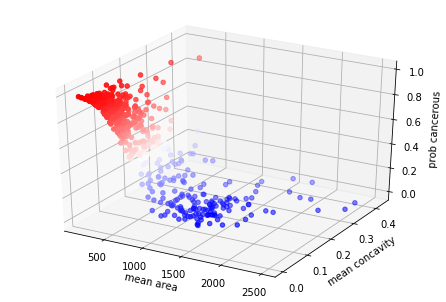

In [184]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()

ax = Axes3D(fig) 

zdata = scoped_df['prediction_probs']
xdata = scoped_df['mean_area']
ydata = scoped_df['mean_concavity']

ax.set_xlabel('mean area', rotation=150)
ax.set_ylabel('mean concavity')
ax.set_zlabel('prob cancerous', rotation=60)

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='bwr');
ax.clabel(fontsize=9, inline=1)
plt.show()

And to convert these into scores...also do in iframe

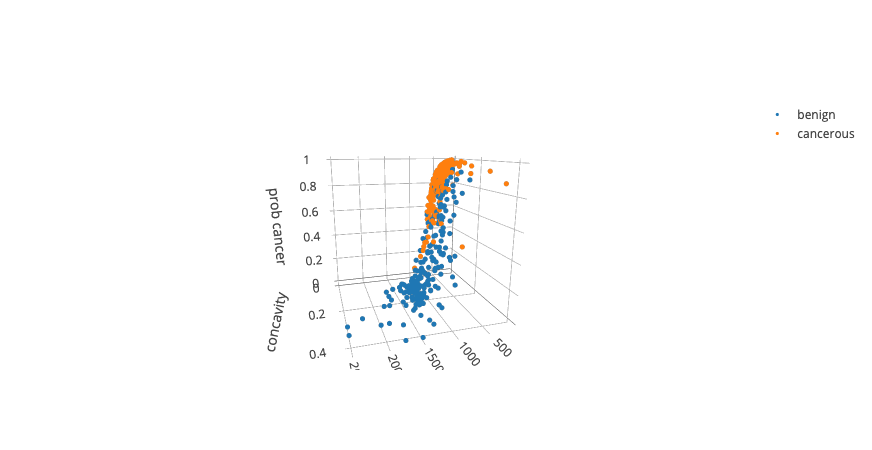

In [185]:
trace_three_d_benign = dict(
        name = 'benign', x = df_benign['mean_area'], y = df_benign['mean_concavity'], z = df_benign['prediction_probs'],
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, line=dict(width=0) ) )

trace_three_d_cancerous = dict(
        name = 'cancerous', x = df_cancerous['mean_area'], y = df_cancerous['mean_concavity'], z = df_cancerous['prediction_probs'],
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, line=dict(width=0) ) )
plot([trace_three_d_benign, trace_three_d_cancerous], {'scene': {'xaxis': {'title': 'area'}, 'yaxis': {'title': 'concavity'}, 'zaxis': {'title': 'prob cancer'}}})

In [ ]:
decision_trace = trace_values(x_values=area_values, y_values=boundaries, mode = 'lines', name = '-3.47*x_1 -0.008*x_2  = 0')

layout = {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'mean concavity', 'range': [0, .5]}, 'title': 'Is it cancerous?'}
plot([non_cancerous_trace, cancerous_trace,  decision_trace], layout = layout)

So from here, we can see our ability to take different attributes, output a score with our decision function, and then use our sigmoid function to translate these into a probability of being cancerous.

And once again, we can use sklearn to do this for us.

In [264]:
X = scoped_df[['mean_area', 'mean_concavity']][:-1]
model.predict_proba(X)[:10, 0]

array([0.96112647, 0.99378651, 0.98870198, 0.12678865, 0.9946646 ,
       0.18393264, 0.94633048, 0.28823469, 0.25927843, 0.22129445])

### Summary

### Resources

[logistic regression cost](https://www.internalpointers.com/post/cost-function-logistic-regression)